Goal: Predict closing prices or detect potential trading signals.using lstm

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input ,LeakyReLU
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [5]:
# df = pd.read_csv(file_path)
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)


In [6]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
file_name = 'AABA_2006-01-01_to_2018-01-01.csv'
file_path = os.path.join(datasets_dir, file_name)
df = pd.read_csv(file_path)

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [8]:
diff_close_series = df['Close'].diff().dropna()

dont make lag feature of actual value make lag feature of diffrences of the values


In [9]:
lagged_data = pd.concat(
    [diff_close_series.shift(i) for i in range(3, -1, -1)],
    axis=1
).dropna()
lagged_data.columns = [f'lag_{i}' for i in range(3, -1, -1)]
X = lagged_data.iloc[:, 1:].values 
y = lagged_data.iloc[:, 0].values   

In [10]:
# lag_df['diff t-1'] = lag_df['t'] - lag_df['t-1'] 
# lag_df['diff t'] = lag_df['t+1'] - lag_df['t']   

In [11]:
# lag_df['rolling_mean_7'] = lag_df['t'].rolling(window=7).mean()
# lag_df['rolling_std_7'] = lag_df['t'].rolling(window=7).std()
# lag_df.dropna(inplace=True)

In [12]:
# X = lag_df[['diff t-1', 't']].values  
# y = lag_df['t+1'].values

In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [14]:

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [15]:
# X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [16]:
X_reshaped = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [17]:
# model = Sequential()
# model.add(LSTM(100, activation='relu', input_shape=(1, X_reshaped.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [18]:
print(lagged_data.head())
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_reshaped shape: {X_reshaped.shape}")
print(f"y_scaled shape: {y_scaled.shape}")

   lag_3  lag_2  lag_1  lag_0
4   0.06   0.56   1.68   0.21
5   0.56   1.68   0.21  -0.44
6   1.68   0.21  -0.44  -1.11
7   0.21  -0.44  -1.11  -0.98
8  -0.44  -1.11  -0.98  -0.99
X shape: (3015, 3)
y shape: (3015,)
X_reshaped shape: (3015, 3, 1)
y_scaled shape: (3015, 1)


In [19]:
model = Sequential()
model.add(Input(shape=(X_reshaped.shape[1], 1)))  # Explicit input layer
model.add(LSTM(50, return_sequences=False))
model.add(LeakyReLU(negative_slope=0.01))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

2025-03-18 12:32:09.118519: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
# history = model.fit(X_reshaped, y_scaled, epochs=100, batch_size=16, verbose=1, validation_split=0.2)

In [21]:
model.fit(X_reshaped, y_scaled, epochs=200, batch_size=8, verbose=0)

In [22]:
y_pred_scaled = model.predict(X_reshaped)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [23]:
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

In [24]:
print(f"MSE: {mse:.6f}")
print(f"R2: {r2:.6f}")

MSE: 0.290948
R2: 0.268343


In [25]:
n = X_reshaped.shape[0]  # Number of samples
k = X_reshaped.shape[1]  # Number of predictors (5 lags)
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [26]:
print(f"Adjusted R2: {adjusted_r2:.6f}")

Adjusted R2: 0.267614


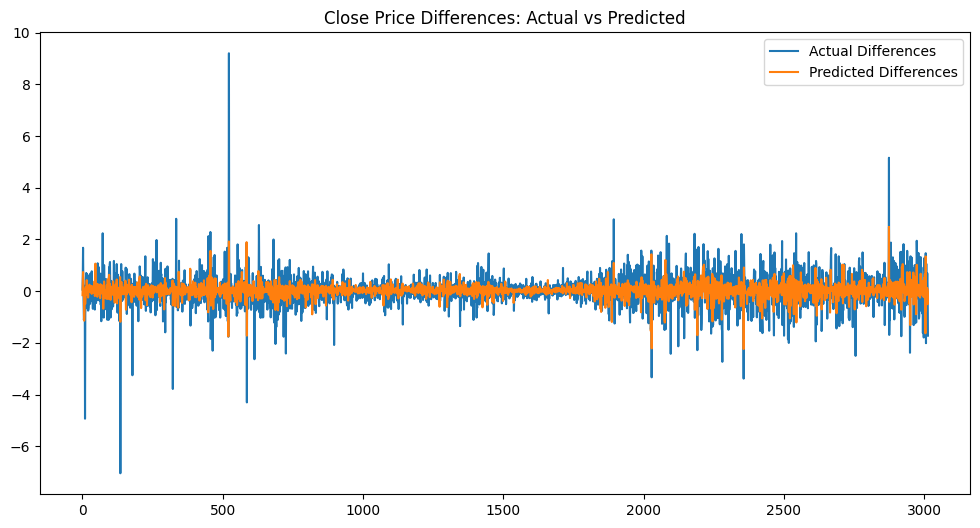

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual Differences')
plt.plot(y_pred, label='Predicted Differences')
plt.title("Close Price Differences: Actual vs Predicted")
plt.legend()
plt.show()

ARIMA

In [28]:
# lagged_data = pd.concat(
#     [diff_close_series.shift(i) for i in range(5, -1, -1)],
#     axis=1
# ).dropna()
# lagged_data.columns = [f'lag_{i}' for i in range(5, -1, -1)]
# X = lagged_data.iloc[:, 1:].values 
# y = lagged_data.iloc[:, 0].values

In [29]:
split_idx = int(len(diff_close_series) * 0.8)
train, test = diff_close_series[:split_idx], diff_close_series[split_idx:]

In [30]:
if not isinstance(train.index, pd.DatetimeIndex):
    train.index = pd.date_range(start='2023-01-01', periods=len(train), freq='D')
model_arima = ARIMA(train, order=(1, 0, 1))
model_arima_fit = model_arima.fit()

In [31]:
print(model_arima_fit.summary())
forecast = model_arima_fit.forecast(steps=5) 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2414
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2202.987
Date:                Tue, 18 Mar 2025   AIC                           4413.973
Time:                        12:34:13   BIC                           4437.129
Sample:                    01-01-2023   HQIC                          4422.395
                         - 08-10-2029                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.011     -0.145      0.885      -0.023       0.019
ar.L1          0.8838      0.099      8.888      0.000       0.689       1.079
ma.L1         -0.9007      0.093     -9.698      0.0

In [32]:
mse_arima = mean_squared_error(test, forecast_arima)
mse_arima

NameError: name 'forecast_arima' is not defined

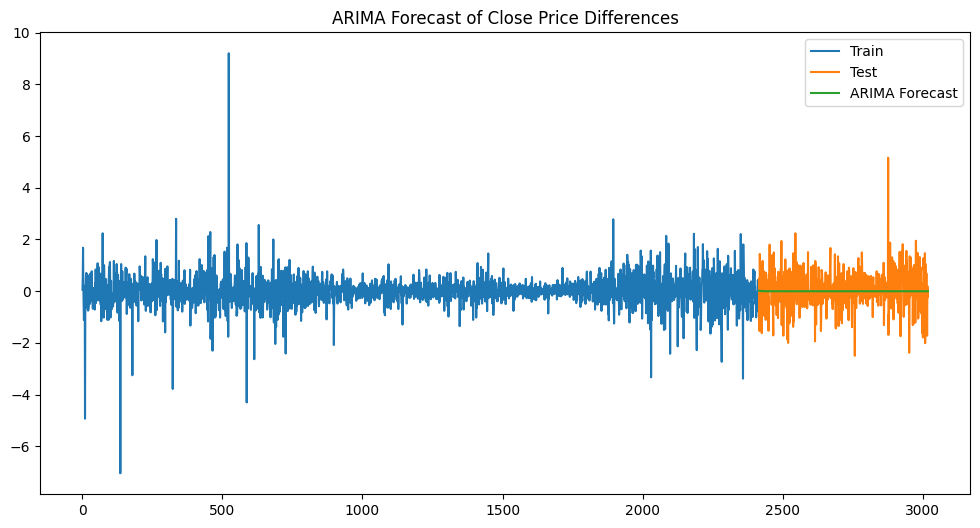

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.title("ARIMA Forecast of Close Price Differences")
plt.legend()
plt.show()

In [ ]:
model_sarima = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)

/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
forecast_sarima = model_sarima_fit.forecast(steps=len(test))

/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ryu/code/minorproject/VENV/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
mse_sarima = mean_squared_error(test, forecast_sarima)
print(f"SARIMA MSE: {mse_sarima:.6f}")

SARIMA MSE: 0.532145


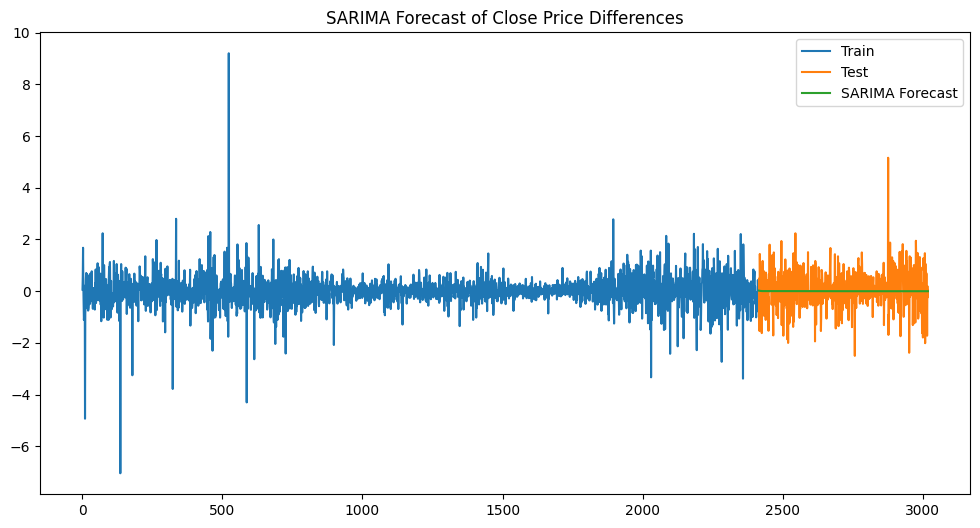

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.title("SARIMA Forecast of Close Price Differences")
plt.legend()
plt.show()